In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

In [17]:

url = "https://api.marketstack.com/v1/eod"
params = {
    "access_key": "a298a7c1dc77a3eeab5ed9f6060cd0ad",
    "symbols": "AAPL"
}

response = requests.get(url, params=params)
print(response.json())
data = response.json()

# Scale data
records = []
for item in data['data']:
    records.append({
        'Date': item['date'],
        'Open': item['open'],
        'High': item['high'],
        'Low': item['low'],
        'Close': item['close'],
        'Volume': item['volume']
    })
df = pd.DataFrame(records)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

{'pagination': {'limit': 100, 'offset': 0, 'count': 100, 'total': 253}, 'data': [{'open': 224.55, 'high': 225.34, 'low': 222.76, 'close': 224.72, 'volume': 45089257.0, 'adj_high': 225.35, 'adj_low': 222.76, 'adj_close': 224.72, 'adj_open': 224.6, 'adj_volume': 45233854.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'AAPL', 'exchange': 'XNAS', 'date': '2024-08-15T00:00:00+0000'}, {'open': 220.57, 'high': 223.03, 'low': 219.7, 'close': 221.72, 'volume': 41888500.0, 'adj_high': 223.03, 'adj_low': 219.7, 'adj_close': 221.72, 'adj_open': 220.57, 'adj_volume': 41960574.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'AAPL', 'exchange': 'XNAS', 'date': '2024-08-14T00:00:00+0000'}, {'open': 219.01, 'high': 221.89, 'low': 219.01, 'close': 221.27, 'volume': 44095400.0, 'adj_high': 221.89, 'adj_low': 219.01, 'adj_close': 221.27, 'adj_open': 219.01, 'adj_volume': 44155331.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'AAPL', 'exchange': 'XNAS', 'date': '2024-08-13T00:00:00+0000'}, {'op

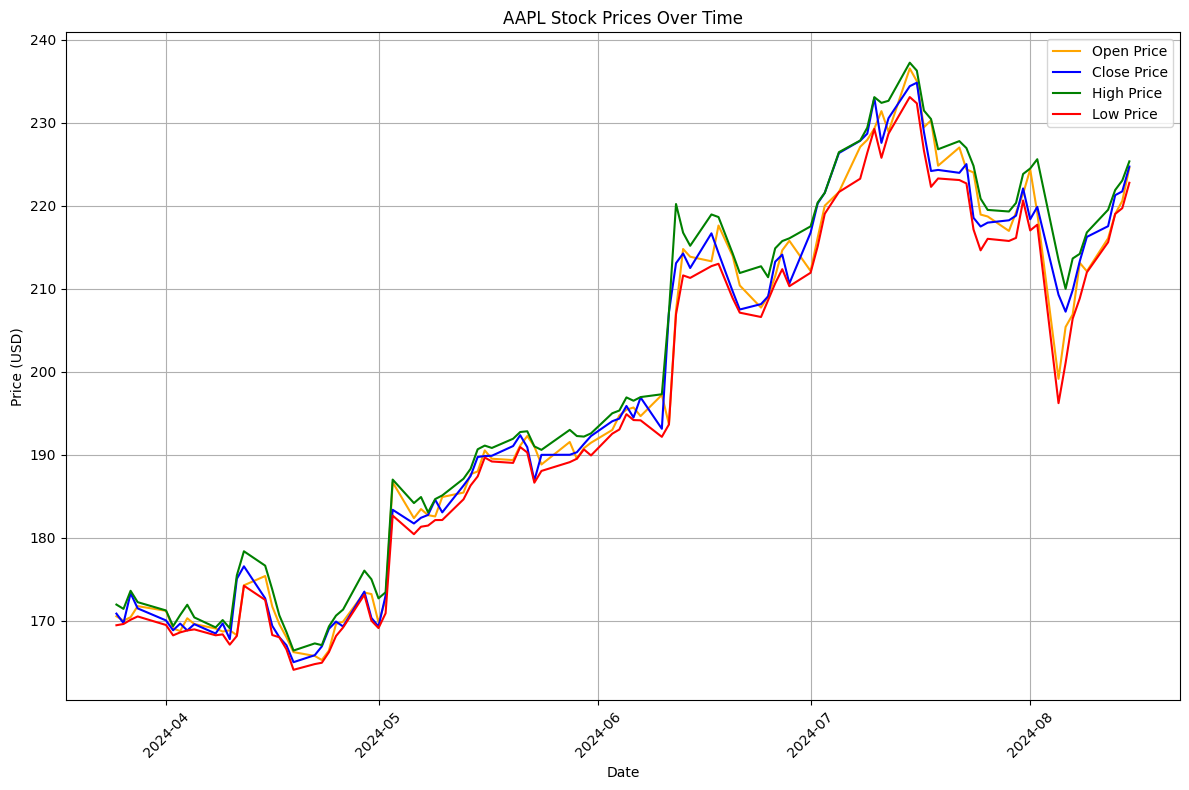

In [3]:
# Visualization
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df['Open'], label='Open Price', color='orange')
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['High'], label='High Price', color='green')
plt.plot(df['Date'], df['Low'], label='Low Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('AAPL Stock Prices Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Textual summaries
def create_textual_summary(row):
    return f"On {row['Date'].strftime('%Y-%m-%d')}, the stock opened at {row['Open']}, reached a high of {row['High']}, and closed at {row['Close']}."

df['text_summary'] = df.apply(create_textual_summary, axis=1)

# Optional: Save the summaries to a CSV for inspection
df[['Date', 'text_summary']].to_csv('stock_summaries.csv', index=False)

In [5]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Adding a padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

## Force CPU usage
device = torch.device("cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
# Define a custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Ensure each item in the encodings dict is accessed correctly
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        # Corrected to access the 'input_ids' through dictionary key access
        return len(self.encodings['input_ids'])


In [7]:
# Tokenize the data
inputs = tokenizer(
    list(df['text_summary']),
    return_tensors='pt',
    max_length=512,
    truncation=True,
    padding=True
)

# Move tensors to device before creating the dataset
inputs = {key: val.to(device) for key, val in inputs.items()}
dataset = TextDataset(inputs)


In [15]:
# Fine-tuning the model (modified)
from torch.nn import CrossEntropyLoss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none"  # Add this line to disable W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Define the loss function as part of the training step
def compute_loss(model, inputs, return_outputs=False):
    # Shift input ids to create labels (assuming causal language modeling task)
    labels = inputs['input_ids'].clone()
    labels[labels == tokenizer.pad_token_id] = -100 # ignore padding tokens in loss calculation
    outputs = model(**inputs, labels=labels)
    return (outputs.loss, outputs) if return_outputs else outputs.loss

trainer.compute_loss = compute_loss  # Assign the compute_loss function to the Trainer instance

trainer.train()

Step,Training Loss


TrainOutput(global_step=75, training_loss=2.7353999837239584, metrics={'train_runtime': 311.5492, 'train_samples_per_second': 0.963, 'train_steps_per_second': 0.241, 'total_flos': 4746124800000.0, 'train_loss': 2.7353999837239584, 'epoch': 3.0})

In [16]:
# Prediction function
def predict_future(input_text):
    inputs = tokenizer(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs['input_ids'], max_length=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example prediction based on recent stock data
future_summary = "On 2024-08-14, the stock opened at 221.27."
predicted_text = predict_future(future_summary)
print(predicted_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


On 2024-08-14, the stock opened at 221.27. The Dow Jones Industrial Average (DJIA) closed at 221.00, the S&P 500 closed at 221.00, and the Nasdaq Composite closed at 221.00.

The Dow Jones industrial average closed at 7.939. The S&P 500 closed at 7.9, the Dow Jones Industrial Average (DJIA) closed at 7.9, and the S&P 500 closed at
